<a href="https://colab.research.google.com/github/mbalbi/ciencia_de_datos/blob/main/notebooks/practica_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 10

- Regresión categórica (o multinomial)
- Regresión de categorías ordenadas
- Regresiones robustas (modelos con sobredispersión)

Se van a requerir las siguientes librerías en esta clase

In [ ]:
import io
import numpy as np
import scipy.stats as st
import scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install pymc
import pymc as pm
import arviz as az
import pandas as pd
import aesara.tensor as at

## Datasets

###  Dataset 1: Frecuencia natural de galpones industriales

fuente: Santiago Bertero, Virginia Tech

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Galpones.csv to Galpones.csv


In [ ]:
#Se crea un DataFrame
df_galpones = pd.read_csv(io.BytesIO(uploaded['Galpones.csv']))
df_galpones.head()

,Frame,W_kip_,Height_in_,L_ft_,alpha,Cladding,Structure,Roof,Seismic,Wind,Weights,k_lat_kip_ft_,MassParticipation,T_model_s_,T_r1_s_,T_r2_s_,T_S_U_s_
0,1,10.21,190.0,40,2.526,Metal Panels,Clear Span,Monoslope,Low,High,0.011666,3.520,0.933,0.546,0.546,0.545,0.707386
1,2,25.16,192.5,100,6.234,Metal Panels,Clear Span,Gabled,Low,High,0.032986,12.459,0.619,0.571,0.560,0.454,0.537498
2,3,46.71,220.0,160,8.727,Metal Panels,Clear Span,Monoslope,High,High,0.001667,27.663,0.423,0.606,0.580,0.415,0.423907
3,4,13.14,400.0,40,1.200,Metal Panels,Clear Span,Gabled,Low,High,0.002174,3.563,0.930,0.602,0.602,0.614,0.953937
4,5,52.23,385.0,100,3.117,Metal Panels,Clear Span,Monoslope,High,Low,0.001058,7.218,0.925,0.881,0.880,0.860,1.208260


### Dataset 2: Niveles de daño en estructuras durante sismo en Nepal (2015)

Fuente: Nguyen and Lallemant (2015) https://onlinelibrary.wiley.com/doi/10.1111/risa.13815

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ordinal_data.csv to ordinal_data.csv


In [ ]:
#Se crea un DataFrame
df_nepal = pd.read_csv(io.BytesIO(uploaded['ordinal_data.csv']))
df_nepal.head()

,building_id,ward_id,long,lat,logPGA,land_surface_condition,foundation_type,roof_type,ground_floor_type,superstructure,damage_grade
0,120101000031,120101,86.525627,27.30483,-1.481803,Flat,Other,Bamboo/Timber-Light roof,Mud,mud_mortar_stone,Grade 2
1,120101000041,120101,86.525627,27.30483,-1.481803,Flat,Other,Bamboo/Timber-Light roof,Mud,mud_mortar_stone,Grade 2
2,120101000051,120101,86.525627,27.30483,-1.481803,Flat,Other,Bamboo/Timber-Light roof,Mud,mud_mortar_stone,Grade 1
3,120101000061,120101,86.525627,27.30483,-1.481803,Flat,Other,Bamboo/Timber-Light roof,Mud,mud_mortar_stone,Grade 2
4,120101000071,120101,86.525627,27.30483,-1.481803,Flat,Other,Bamboo/Timber-Light roof,Mud,mud_mortar_stone,Grade 5


## Ejemplo 1: regresión categórica sin predictores

Dataset sintético

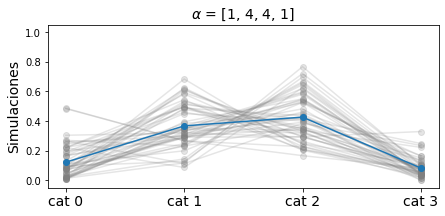

In [ ]:
# Simular variables con Dirichlet
Nk = 4
alphas = [1,4,4,1]
pk = st.dirichlet.rvs( size=50, alpha=alphas, random_state=4846 )

# Ploteo de simulaciones
fig, ax = plt.subplots( figsize=(7,3) )

ax.plot( np.arange(Nk), pk.T, 'C0o-', alpha=.2, color='gray' )
ax.plot( np.arange(Nk), pk.mean(axis=0), 'C0o-' )

ax.set_xticks( np.arange(Nk) )
ax.set_xticklabels( ['cat '+str(i) for i in range(Nk)], fontsize=14 )
ax.set_ylabel( 'Simulaciones', fontsize=14 )
ax.set_ylim([-0.05,1.05])
ax.set_title( r'$\alpha$ = '+str(alphas), fontsize=14 );

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


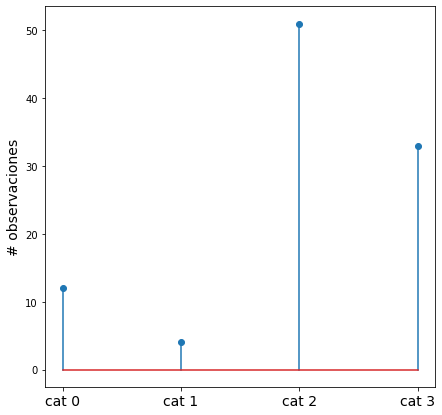

In [ ]:
# Simulación de variables categóricas

Nk = 4 # Cantidad de categorías
ps = [0.15,0.05,0.5,0.3] # Probabilidad de cada categoría

# Simulaciones
Nsim = 100
y = np.random.choice( 4, p=ps, size=Nsim )

# Ploteo
fig, ax = plt.subplots( figsize=(7,7) )
ax.stem( np.arange(Nk), [(y==i).sum() for i in range(Nk)] )

ax.set_xticks( np.arange(Nk) )
ax.set_xticklabels( ['cat '+str(i) for i in range(Nk)], fontsize=14 )
ax.set_ylabel( '# observaciones', fontsize=14 );

In [ ]:
# Inferencia de modelo sin predictores
with pm.Model() as model_11:
    # Priori
    p_ = pm.Dirichlet("p_", a=np.ones(Nk))
    
    # Verosimilitud
    Y = pm.Categorical("y", p=p_, observed=y)

    # Prior predictive
    prior_check_11 = pm.sample_prior_predictive( samples=1000 )

    # Posterior de parámetros
    trace_11 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva
    pm.sample_posterior_predictive( trace_11, extend_inferencedata=True)

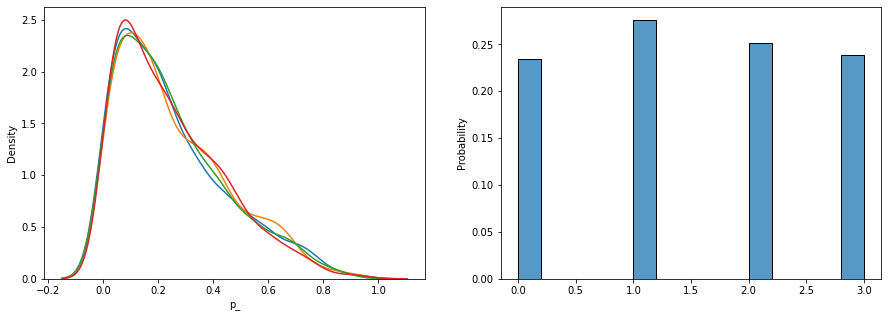

In [ ]:
# Posterior predictive
fig, ax = plt.subplots( figsize=(15,5), ncols=2 )
_ = [sns.kdeplot( prior_check_11.prior['p_'][0,:,i], ax=ax[0] ) for i in range(Nk)]
_ = sns.histplot( prior_check_11.prior_predictive['y'][0,:,0],
                  stat='probability', ax=ax[1] )

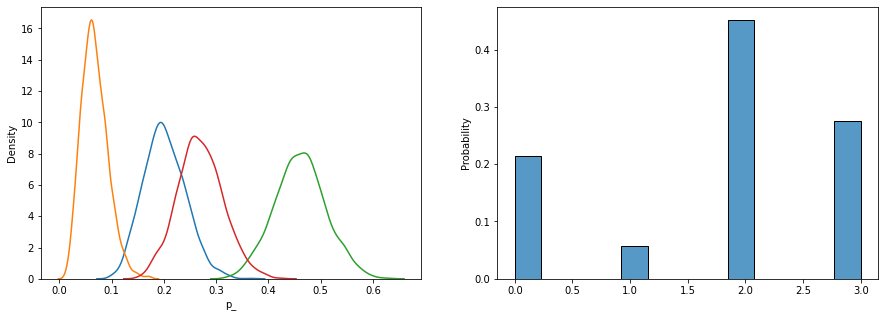

In [ ]:
# Posterior predictive
fig, ax = plt.subplots( figsize=(15,5), ncols=2 )
_ = [sns.kdeplot( trace_11.posterior['p_'][0,:,i], ax=ax[0] ) for i in range(Nk)]
_ = sns.histplot( trace_11.posterior_predictive['y'][0,:,0],
                  stat='probability', ax=ax[1] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


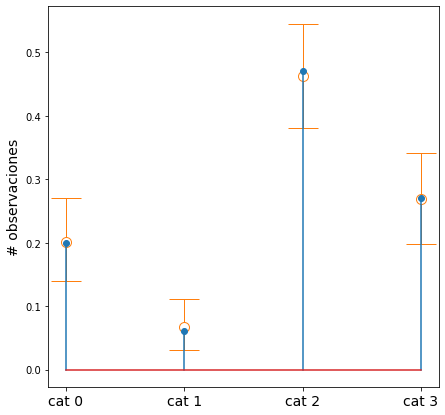

In [ ]:
# Ploteo
fig, ax = plt.subplots( figsize=(7,7) )

# Posterior
p_mean = trace_11.posterior['p_'].mean(['chain','draw'])
p_qi = trace_11.posterior['p_'].quantile(q=0.05, dim=['chain','draw'])
p_qf = trace_11.posterior['p_'].quantile(q=0.95, dim=['chain','draw'])

ax.errorbar( x=np.arange(Nk), y=p_mean, yerr=np.stack([p_mean-p_qi,p_qf-p_mean]),
             color='C1', capsize=15, linewidth=0, markersize=10, marker='o',
             markerfacecolor='w', zorder=0, elinewidth=1  )

# Proporción de observaciones
ax.stem( np.arange(Nk), [(y==i).sum()/y.size for i in range(Nk)] )

ax.set_xticks( np.arange(Nk) )
ax.set_xticklabels( ['cat '+str(i) for i in range(Nk)], fontsize=14 )
ax.set_ylabel( '# observaciones', fontsize=14 );

## Ejemplo 2: Regresión categórica con predictores

Regresión de tipología estructural (categórica) versus período natural y peso del galpón

In [ ]:
# Nueva columna de tipologia estructural
df_galpones['tipologia'] = df_galpones['Cladding'] + '\n' + df_galpones['Structure']
df_galpones['tipologia'] = df_galpones['tipologia'].astype('category')
df_galpones['tipologia_cod'] = df_galpones['tipologia'].cat.codes
df_galpones.head()

,Frame,W_kip_,Height_in_,L_ft_,alpha,Cladding,Structure,Roof,Seismic,Wind,Weights,k_lat_kip_ft_,MassParticipation,T_model_s_,T_r1_s_,T_r2_s_,T_S_U_s_,tipologia,tipologia_cod
0,1,10.21,190.0,40,2.526,Metal Panels,Clear Span,Monoslope,Low,High,0.011666,3.520,0.933,0.546,0.546,0.545,0.707386,Metal Panels\nClear Span,2
1,2,25.16,192.5,100,6.234,Metal Panels,Clear Span,Gabled,Low,High,0.032986,12.459,0.619,0.571,0.560,0.454,0.537498,Metal Panels\nClear Span,2
2,3,46.71,220.0,160,8.727,Metal Panels,Clear Span,Monoslope,High,High,0.001667,27.663,0.423,0.606,0.580,0.415,0.423907,Metal Panels\nClear Span,2
3,4,13.14,400.0,40,1.200,Metal Panels,Clear Span,Gabled,Low,High,0.002174,3.563,0.930,0.602,0.602,0.614,0.953937,Metal Panels\nClear Span,2
4,5,52.23,385.0,100,3.117,Metal Panels,Clear Span,Monoslope,High,Low,0.001058,7.218,0.925,0.881,0.880,0.860,1.208260,Metal Panels\nClear Span,2


### Sin predictores

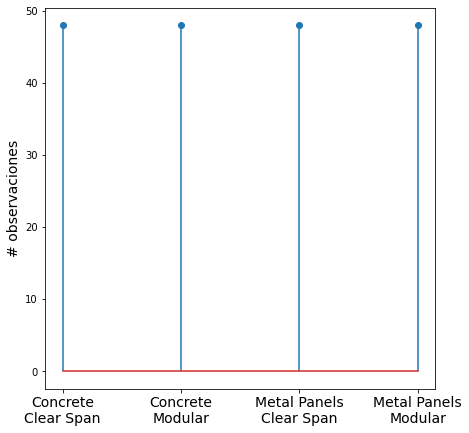

In [ ]:
y = df_galpones['tipologia_cod']
cat_names = df_galpones['tipologia'].cat.categories

# Ploteo
fig, ax = plt.subplots( figsize=(7,7) )

ax.stem( np.arange(4), y.value_counts(), use_line_collection=True )

ax.set_xticks( np.arange(4) )
ax.set_xticklabels( cat_names, fontsize=14 )
ax.set_ylabel( '# observaciones', fontsize=14 );

In [ ]:
# Inferencia de distribución categórica sin predictores
with pm.Model() as model_21:
      
    # Distribuciones a priori
    alpha = pm.Normal("alpha", 0.0, 1.5, shape=3)

    # Scores
    s0 = pm.math.zeros_like( alpha[0] ) # pivot
    s1 = alpha[0]
    s2 = alpha[1]
    s3 = alpha[2]
    s = pm.math.stack([s0, s1, s2, s3]).T

    # Probabilidades
    p_ = pm.Deterministic( "p_", at.nnet.softmax(s,axis=-1) )

    # Verosimilitud
    Y = pm.Categorical( "y", p=p_, observed=y )
    
    # Prior predictive
    prior_check_21 = pm.sample_prior_predictive( samples=1000 )

    # Simulaciones posteriores
    trace_21 = pm.sample( 3000, tune=2000, cores=2 )

    # Simulaciones predictivas
    pm.sample_posterior_predictive( trace_21, extend_inferencedata=True )

/usr/local/lib/python3.7/dist-packages/aesara/tensor/nnet/basic.py:1128: UserWarning: Softmax no longer converts a vector to a row matrix.
  UserWarning,


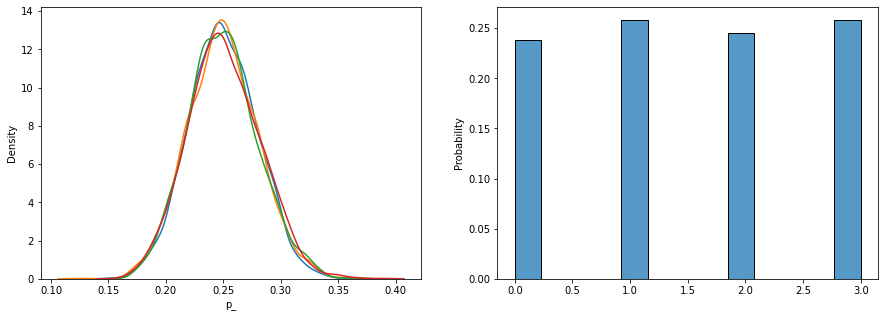

In [ ]:
# Posterior predictive
fig, ax = plt.subplots( figsize=(15,5), ncols=2 )
_ = [sns.kdeplot( trace_21.posterior['p_'][0,:,i], ax=ax[0] ) for i in range(4)]
_ = sns.histplot( trace_21.posterior_predictive['y'][0,:,0],
                  stat='probability', ax=ax[1] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


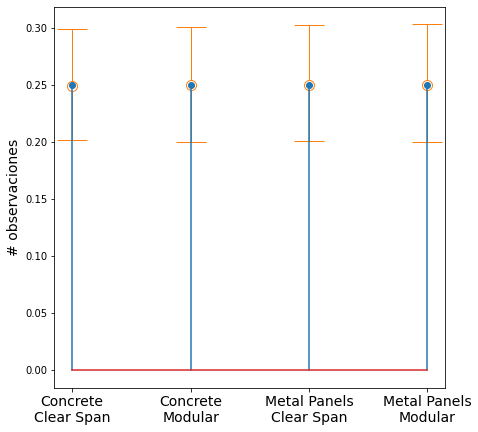

In [ ]:
# Ploteo
fig, ax = plt.subplots( figsize=(7,7) )

# Posterior
p_mean = trace_21.posterior['p_'].mean(['chain','draw'])
p_qi = trace_21.posterior['p_'].quantile(q=0.05, dim=['chain','draw'])
p_qf = trace_21.posterior['p_'].quantile(q=0.95, dim=['chain','draw'])

ax.errorbar( x=np.arange(4), y=p_mean, yerr=np.stack([p_mean-p_qi,p_qf-p_mean]),
             color='C1', capsize=15, linewidth=0, markersize=10, marker='o',
             markerfacecolor='w', zorder=0, elinewidth=1  )

# Proporción de observaciones
ax.stem( np.arange(4), [(y==i).sum()/y.size for i in range(4)] )

ax.set_xticks( np.arange(4) )
ax.set_xticklabels( cat_names, fontsize=14 )
ax.set_ylabel( '# observaciones', fontsize=14 );

### Con predictores

In [ ]:
x = df_galpones['T_model_s_'].to_numpy()
x = (x-x.mean())/x.std()
y = df_galpones['tipologia_cod'].to_numpy()

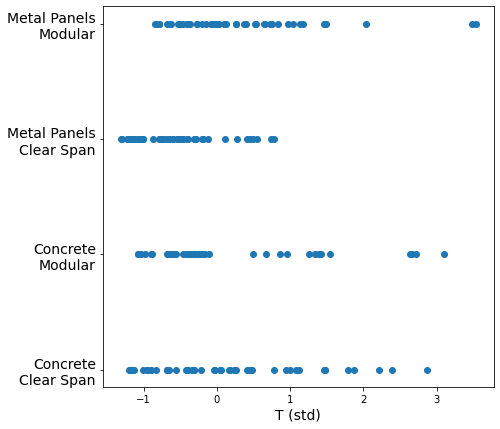

In [ ]:
fig, ax = plt.subplots( figsize=(7,7) )

ax.plot( x, y, 'C0o' )

# ax.vlines( x=1, ymin=-0.05, ymax=3.05, color='gray', linestyle='--', alpha=.5)
# ax.vlines( x=2.5, ymin=-0.05, ymax=3.05, color='gray', linestyle='--', alpha=.5)

ax.set_xlabel('T (std)', fontsize=14)
ax.set_yticks( np.arange(4) )
ax.set_yticklabels( cat_names, fontsize=14 );

In [ ]:
# Regresión categórica con el período natural como predictor
with pm.Model() as model_22:
    
    X = pm.MutableData( "x", x )
    
    # Distribuciones a priori
    alpha = pm.Normal("alpha", 0.0, 1.5, shape=3)
    beta = pm.Normal("beta", 0.0, 1.5, shape=3)

    # Scores
    s0 = pm.math.zeros_like( X ) # pivot
    s1 = alpha[0] + beta[0] * X
    s2 = alpha[1] + beta[1] * X
    s3 = alpha[2] + beta[2] * X
    s = pm.math.stack([s0, s1, s2, s3]).T

    # Probabilidades
    p_ = pm.Deterministic( "p_", at.nnet.softmax(s,axis=-1) )

    # Verosimilitud
    Y = pm.Categorical( "y", p=p_, observed=y )
    
    # Prior predictive
    prior_check_22 = pm.sample_prior_predictive( samples=1000 )

    # Simulaciones posteriores
    trace_22 = pm.sample( 3000, tune=2000, cores=2 )

    # Simulaciones predictivas
    pm.sample_posterior_predictive( trace_22, extend_inferencedata=True )

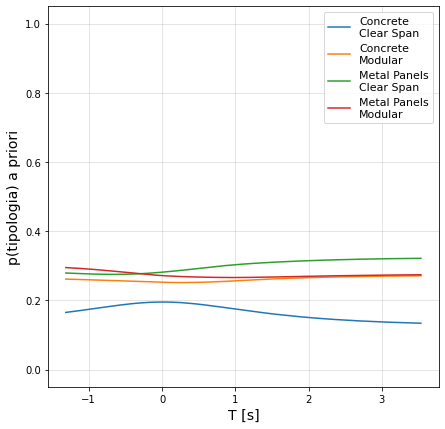

In [ ]:
# Ploteo de predicciones a priori
fig, ax = plt.subplots( figsize=(7,7) )

# Predicciones medias
ix = np.argsort(x)
for i in range(4):
    ax.plot( x[ix], prior_check_22.prior['p_'].mean(['chain','draw'])[ix,i],
             color='C'+str(i), label=cat_names[i] )

ax.set_xlabel('T [s]', fontsize=14)
ax.set_ylabel('p(tipologia) a priori', fontsize=14)
ax.set_ylim([-0.05,1.05])
ax.grid( which='both', alpha=.4 )
ax.legend( fontsize=11 );

In [ ]:
# Simulaciones posteriores predictivas (para plotear mejor)
xtest = np.arange( x.min(), x.max(), 0.01 )
with model_22:
    pm.set_data({"x":xtest})
    ppc_22 = pm.sample_posterior_predictive( trace_22, var_names=['y','p_'] )

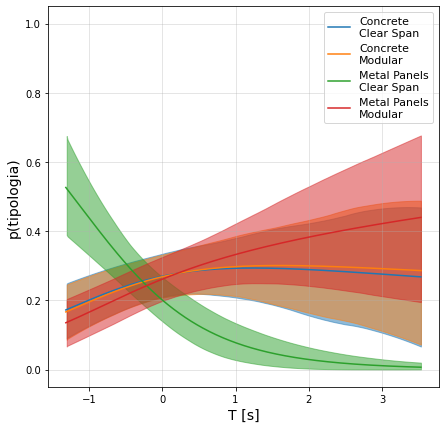

In [ ]:
# Ploteo de distribuciones posteriores de p en función de x
fig, ax = plt.subplots( figsize=(7,7) )

for i in range(4):
    # Predicciones posteriores medias
    ax.plot( xtest, ppc_22.posterior_predictive['p_'].mean(['chain','draw'])[:,i],
             color='C'+str(i), label=cat_names[i] )
    # HDI de predicciones posteriores
    az.plot_hdi( xtest, ppc_22.posterior_predictive['p_'][:,:,:,i], color='C'+str(i))

ax.set_xlabel('T [s]', fontsize=14)
ax.set_ylabel('p(tipologia)', fontsize=14)
ax.set_ylim([-0.05,1.05])
ax.grid( which='both', alpha=.4 )
ax.legend( fontsize=11 );

### Con 2 predictores

- X1: período natural
- X2: peso del galpón

In [ ]:
x1 = df_galpones['T_model_s_'].to_numpy()
x1 = (x1-x1.mean())/x1.std()
x2 = df_galpones['W_kip_'].to_numpy()
x2 = (x2-x2.mean())/x2.std()
y = df_galpones['tipologia_cod'].to_numpy()

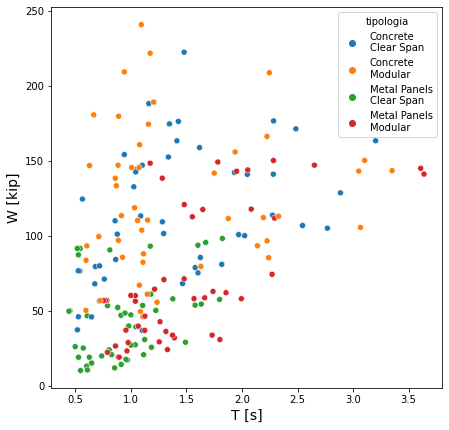

In [ ]:
# Gráfico de las observaciones
fig, ax = plt.subplots( figsize=(7,7) )

sns.scatterplot( data=df_galpones, x='T_model_s_', y='W_kip_', hue='tipologia')

ax.set_xlabel('T [s]', fontsize=14)
ax.set_ylabel('W [kip]', fontsize=14);

In [ ]:
# Modelo de regresión categórica en función de período natural y peso
with pm.Model() as model_23:
    
    X1 = pm.MutableData( "x1", x1 )
    X2 = pm.MutableData( "x2", x2 )
    
    # Distribuciones a priori
    alpha = pm.Normal("alpha", 0.0, 1.5, shape=3)
    beta = pm.Normal("beta", 0.0, 1.0, shape=3)
    gamma = pm.Normal("gamma", 0.0, 1.0, shape=3)

    # Scores
    s0 = pm.math.zeros_like( X1 ) # pivot
    s1 = alpha[0] + beta[0] * X1 + gamma[0] * X2
    s2 = alpha[1] + beta[1] * X1 + gamma[1] * X2
    s3 = alpha[2] + beta[2] * X1 + gamma[2] * X2
    s = pm.math.stack([s0, s1, s2, s3]).T

    # Probabilidades
    p_ = pm.Deterministic( "p_", at.nnet.softmax(s,axis=-1) )

    # Verosimilitud
    Y = pm.Categorical( "y", p=p_, observed=y )
    
    # Simulaciones posteriores
    trace_23 = pm.sample( 3000, tune=2000, cores=2 )

    # Simulaciones predictivas
    pm.sample_posterior_predictive( trace_23, extend_inferencedata=True )

In [ ]:
# Simulaciones posteriores predictivas para xtest (plotear mejor)
coordsx1 = np.arange(x1.min(),x1.max(),0.05)
coordsx2 = np.arange(x2.min(),x2.max(),0.05)
x1test, x2test = np.meshgrid( coordsx1, coordsx2 )
with model_23:
    pm.set_data({'x1':x1test.flatten(), 'x2':x2test.flatten()})
    ppc_23 = pm.sample_posterior_predictive( trace_23, var_names=['y','p_'] )

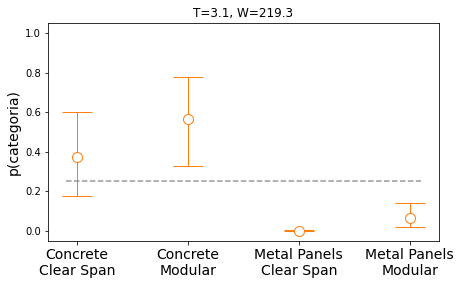

In [ ]:
# Puntos a graficar posteriores del dominio de x1 y x2
pxs = [5,40,80,10,40,80,40,60,80] # indices
pys = [5,5,5,40,40,40,80,80,80] # indices
ix_flat = list( np.ravel_multi_index([pxs,pys], x1test.shape) )

pp_small = ppc_23.posterior_predictive['p_'][:,:,ix_flat,:]
pp_mean = pp_small.mean(dim=['chain','draw'])
pp_qs = pp_small.quantile(q=0.95, dim=['chain','draw'])
pp_qi = pp_small.quantile(q=0.05, dim=['chain','draw'])

# Ploteo
fig, ax = plt.subplots( figsize=(7,4) )

i = 8 # punto a plotear de los pxs y pys
Ti = x1test.flatten()[ix_flat[i]] * df_galpones['T_model_s_'].std() + df_galpones['T_model_s_'].mean()
Wi = x2test.flatten()[ix_flat[i]] * df_galpones['W_kip_'].std() + df_galpones['W_kip_'].mean()

# Error bars
ax.errorbar( x=np.arange(4), y=pp_mean[i,:],
             yerr=np.stack([pp_mean[i,:]-pp_qi[i,:],pp_qs[i,:]-pp_mean[i,:]]),
             color='C1', capsize=15, linewidth=0, markersize=10, marker='o',
             markerfacecolor='w', zorder=0, elinewidth=1  )

# Formateo
ax.hlines( xmin=-0.1, xmax=3.1, y=0.25, color='gray', linestyle='--', alpha=.8 )

ax.set_xticks( np.arange(4) )
ax.set_xticklabels( cat_names, fontsize=14 )
ax.set_ylim([-0.05,1.05])
ax.set_ylabel( 'p(categoria)', fontsize=14 )
ax.set_title( 'T={:.1f}, W={:.1f}'.format(Ti,Wi) );

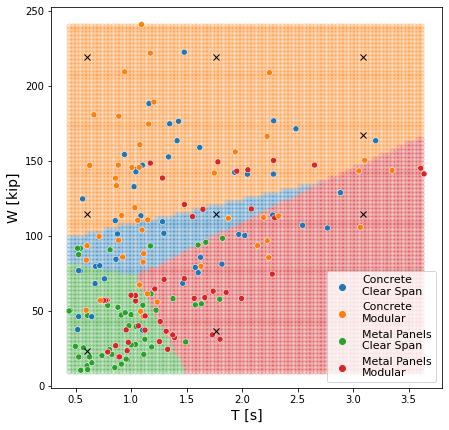

In [ ]:
# Grafico de clasificación posterior
cat_max = ppc_23.posterior_predictive['p_'].mean(['chain','draw']).argmax( dim='p__dim_1' )

# Ploteo de curva p=0.5 media
fig, ax = plt.subplots( figsize=(7,7) )

# Observaciones
cat_pred = cat_max.values.reshape( x1test.shape )
x1p = x1test * df_galpones['T_model_s_'].std() + df_galpones['T_model_s_'].mean()
x2p = x2test * df_galpones['W_kip_'].std() + df_galpones['W_kip_'].mean()
for i in range(4):
  ax.scatter( x1p[cat_pred==i], x2p[cat_pred==i], color='C'+str(i),
              alpha=.2, s=30)

# Observaciones
sns.scatterplot( data=df_galpones, x='T_model_s_', y='W_kip_', hue='tipologia')

for i in range( len(pxs) ):
  ax.plot( x1p[pxs[i],pys[i]], x2p[pxs[i],pys[i]], 'kx' )

# Formateo
ax.set_xlabel('T [s]', fontsize=14)
ax.set_ylabel('W [kip]', fontsize=14)
ax.legend( fontsize=11 );

In [ ]:
# Comparación de modelos
models_list = {'p ~ 1':trace_21, 'p ~ x1':trace_22, 'p ~ x1 + x2':trace_23}
models_comp = az.compare( models_list )
models_comp

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
p ~ x1 + x2,0,-219.870093,8.024937,0.000000,1.000000e+00,7.179911,0.000000,False,log
p ~ x1,1,-259.654229,5.953257,39.784136,0.000000e+00,4.114429,6.457951,False,log
p ~ 1,2,-269.255276,3.086204,49.385183,4.193867e-11,0.040321,7.173277,False,log


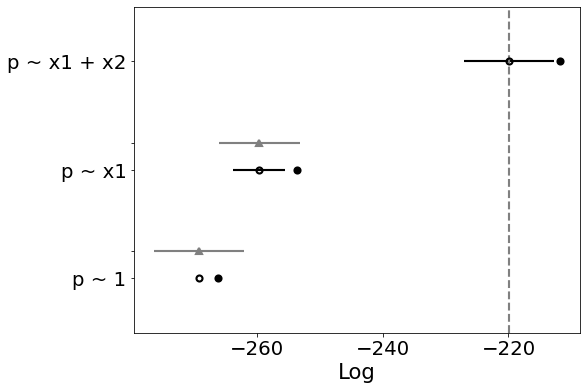

In [ ]:
az.plot_compare( models_comp, figsize=(8,6) );

## Distribución categórica ordinal

Simulación de distribución categórica ordinal e inferencia de la distribución a partir de observaciones

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


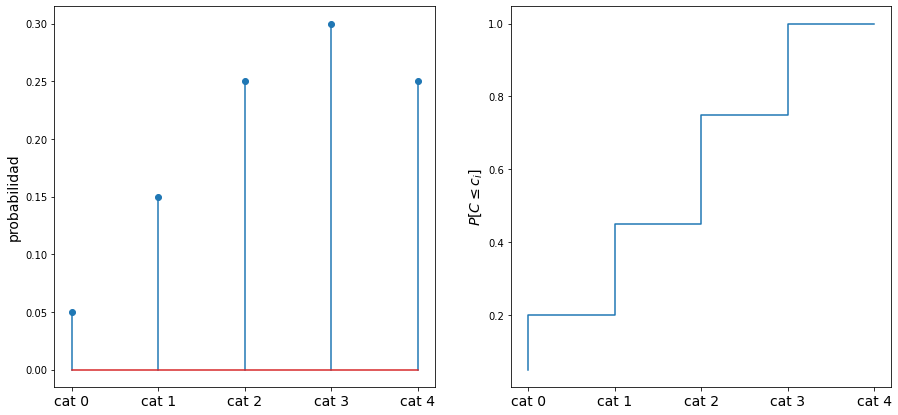

In [ ]:
# Simulación de una variable categórica cualquiera

Nk = 5 # Cantidad de categorías
ps = [0.05,0.15,0.25,0.3,0.25] # Probabilidad de cada categoría
cat_names = ['cat 0','cat 1','cat 2','cat 3','cat 4']

# Simulaciones
Nsim = 500
y = np.random.choice( Nk, p=ps, size=Nsim )

# Ploteo
fig, ax = plt.subplots( figsize=(15,7), ncols=2 )

# Probabilidad
ax[0].stem( np.arange(Nk), ps )

# Probabilidad acumulada
ax[1].step( np.arange(Nk), np.array(ps).cumsum() )

ax[0].set_xticks( np.arange(Nk) )
ax[0].set_xticklabels( cat_names, fontsize=14 )
ax[0].set_ylabel( 'probabilidad', fontsize=14 );

ax[1].set_xticks( np.arange(Nk) )
ax[1].set_xticklabels( cat_names, fontsize=14 )
ax[1].set_ylabel( r'$P[C \leq c_i]$', fontsize=14 );

In [ ]:
# Simulación de qs a través de distribución de Dirichlet
Nsim = 3000
alphas = [1,1,1,1,1]
rp = st.dirichlet.rvs( size=Nsim, alpha=alphas, random_state=1234 )
rq = rp.cumsum( axis=1 )

# # Ploteo
fig, ax = plt.subplots( figsize=(7,3) )

ax.step( np.arange(5), rq.T, 'C0o-', alpha=.2, color='gray' )
ax.step( np.arange(5), rq.mean(axis=0), 'C0o-' )

ax.set_xticks( np.arange(Nk) )
ax.set_xticklabels( ['cat '+str(i) for i in range(Nk)], fontsize=14 )
ax.set_ylabel( 'Simulaciones', fontsize=14 )
ax.set_ylim([-0.05,1.05])
ax.set_title( r'$\alpha$ = '+str(alphas), fontsize=14 );

Text(0.5, 1.0, '$\\alpha$ = [1, 1, 1, 1, 1]')

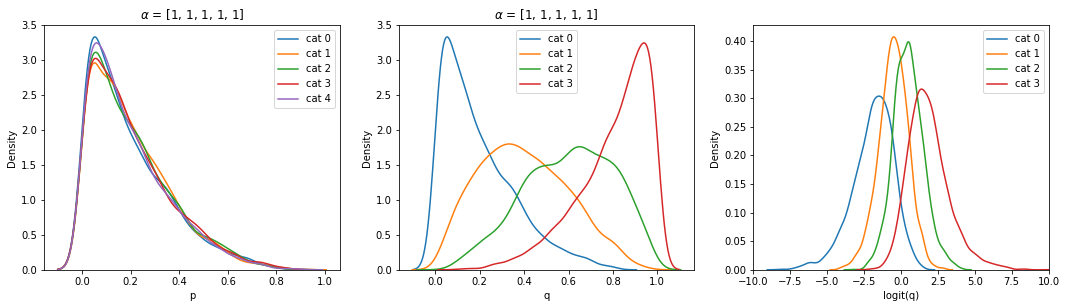

In [ ]:
# Predicciones a priori
fig, ax = plt.subplots( figsize=(18,4.5), ncols=3 )
_ = [ sns.kdeplot( sp.logit(rq)[:,i], ax=ax[2], label='cat '+str(i) ) for i in range(4) ]
_ = [ sns.kdeplot( rp[:,i], ax=ax[0], label='cat '+str(i) ) for i in range(5) ]
_ = [ sns.kdeplot( rq[:,i], ax=ax[1], label='cat '+str(i) ) for i in range(4) ]

ax[2].set_xlim([-10,10])
ax[2].set_xlabel('logit(q)')
ax[2].legend()
ax[0].set_xlabel('p')
ax[0].legend()
ax[1].set_xlabel('q')
ax[1].legend()
ax[0].set_title( r'$\alpha$ = '+str(alphas), fontsize=12)
ax[1].set_title( r'$\alpha$ = '+str(alphas), fontsize=12);

In [ ]:
# Simulación de qs a través de transformación ordinal de Normales
with pm.Model() as model_30:
    # Priori
    kappa = pm.Normal( "kappa", 0.0, 0.5,
                       transform=pm.distributions.transforms.ordered,
                       shape=Nk-1, initval=np.arange(Nk-1) - 2 )

    # Probabilidades acumuladas
    q = pm.Deterministic( 'q', pm.math.invlogit(kappa) )
    
    # Verosimilitud
    Y = pm.OrderedLogistic("y", 0.0, kappa)

    # Posterior de parámetros
    trace_30 = pm.sample( 3000, tune=2000, cores=2 )

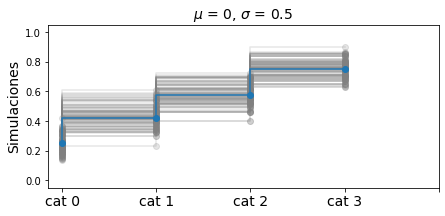

In [ ]:
# Gráficos de las simulaciones
rq = trace_30.posterior['q'].stack(sample=['chain','draw']).values

# Ploteo
fig, ax = plt.subplots( figsize=(7,3) )

ax.step( np.arange(4), rq[:,:100], 'C0o-', alpha=.2, color='gray' )
ax.step( np.arange(4), rq.mean(axis=1), 'C0o-' )

ax.set_xticks( np.arange(Nk) )
ax.set_xticklabels( ['cat '+str(i) for i in range(Nk-1)], fontsize=14 )
ax.set_ylabel( 'Simulaciones', fontsize=14 )
ax.set_ylim([-0.05,1.05])
ax.set_title( r'$\mu$ = 0, $\sigma$ = '+str(0.5), fontsize=14 );

Text(0.5, 1.0, '$\\mu$ = 0, $\\sigma$ = 0.5')

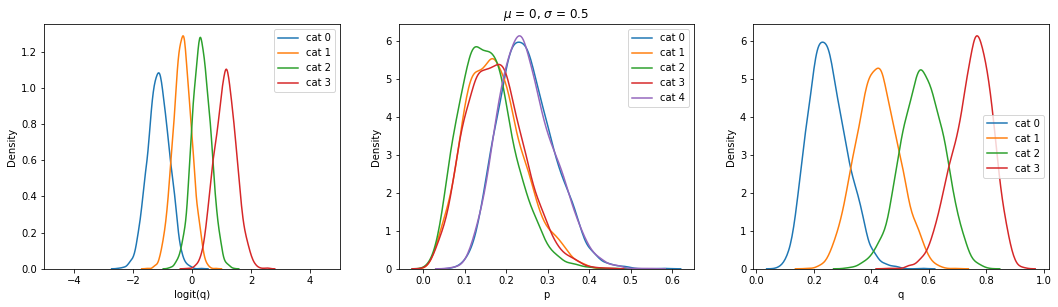

In [ ]:
# Predicciones a priori
fig, ax = plt.subplots( figsize=(18,4.5), ncols=3 )
_ = [sns.kdeplot( trace_30.posterior['kappa'][0,:,i], ax=ax[0], label='cat '+str(i) ) for i in range(4) ]
_ = [sns.kdeplot( trace_30.posterior['y_probs'][0,:,i], ax=ax[1], label='cat '+str(i) ) for i in range(5) ]
_ = [sns.kdeplot( trace_30.posterior['q'][0,:,i], ax=ax[2], label='cat '+str(i) ) for i in range(4)]

ax[0].set_xlim([-5,5])
ax[0].set_xlabel('logit(q)')
ax[0].legend()
ax[1].set_xlabel('p')
ax[1].legend()
ax[2].set_xlabel('q')
ax[2].legend()
ax[1].set_title(r'$\mu$ = 0, $\sigma$ = 0.5', fontsize=12)

## Ejemplo 3: Regresión de categorías ordenadas

Regresión del estado de daño (DS) en función del PGA para el daño por el sismo de Nepal

In [ ]:
# Curado del dataset

# Remover nans de columnas de interes
df_nepal_clean = df_nepal.dropna()

# Modificar columna de 'damage_grade' como categórica
df_nepal_clean['damage_grade'] = df_nepal_clean['damage_grade'].astype('category')

# Crear nueva columna con números enteros ordinales para las categorías
cat_codes = {'Grade 1': 1, 'Grade 2': 2, 'Grade 3': 3,
             'Grade 4': 4, 'Grade 5': 5}
df_nepal_clean['damage_grade_cat'] = df_nepal_clean['damage_grade'].cat.rename_categories( cat_codes )

# Seleccionar estructuras de madera únicamente
df_nepal_clean = df_nepal_clean[ df_nepal_clean['superstructure'] == 'timber' ]

df_nepal_clean.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,building_id,ward_id,long,lat,logPGA,land_surface_condition,foundation_type,roof_type,ground_floor_type,superstructure,damage_grade,damage_grade_cat
1454,120303000231,120303,86.296151,27.265291,-1.360213,Moderate slope,Bamboo/Timber,Bamboo/Timber-Light roof,Mud,timber,Grade 3,3
2018,120405000371,120405,86.537752,27.359212,-1.676560,Flat,Bamboo/Timber,Bamboo/Timber-Light roof,Mud,timber,Grade 1,1
3221,120509000011,120509,86.498566,27.346625,-1.615302,Flat,Bamboo/Timber,Bamboo/Timber-Light roof,Mud,timber,Grade 5,5
4556,120802000131,120802,86.397139,27.501566,-1.225476,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Timber,timber,Grade 4,4
4599,120803000281,120803,86.380155,27.513195,-1.149215,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Timber,timber,Grade 4,4


### Sin predictores

In [ ]:
y = df_nepal_clean['damage_grade_cat'].to_numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()


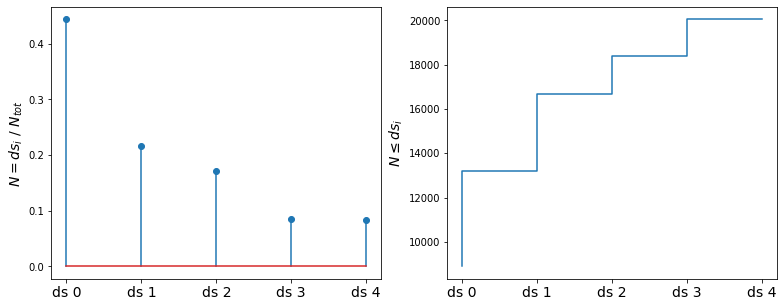

In [ ]:
# Gráfico de la distribución marginal de y

# Categorías acumuladas
dg_acum = df_nepal_clean['damage_grade_cat'].value_counts(sort=False).cumsum()
dg_acum_prop = dg_acum/dg_acum[-1]

# Ploteo
fig, ax = plt.subplots( figsize=(13,5), ncols=2 )

# Función de probabilidad
ax[0].stem( np.arange(1,6), df_nepal_clean['damage_grade_cat'].value_counts(sort=False)/y.size )

# Función acumulada (de excedencia)
ax[1].step( np.arange(1,6), dg_acum )

ax[0].set_xticks( np.arange(1,6) )
ax[0].set_xticklabels( ['ds '+str(i) for i in range(5)], fontsize=14 )
ax[0].set_ylabel(r'$N = ds_i$ / $N_{tot}$', fontsize=14);

ax[1].set_xticks( np.arange(1,6) )
ax[1].set_xticklabels( ['ds '+str(i) for i in range(5)], fontsize=14 )
ax[1].set_ylabel(r'$N \leq ds_i$', fontsize=14);

In [ ]:
# Inferencia de los parámetros de la distribución marginal
with pm.Model() as model_31:
    # Priori
    kappa = pm.Normal( "kappa", 0.0, 1.5,
                       transform=pm.distributions.transforms.ordered,
                       shape=4, initval=np.arange(4) - 2 )

    # Probabilidades acumuladas
    q = pm.Deterministic( 'q', pm.math.invlogit(kappa) )
    
    # Verosimilitud
    Y = pm.OrderedLogistic("y", 0.0, kappa, observed=y-1)

    # Posterior de parámetros
    trace_31 = pm.sample( 3000, tune=2000, cores=2 )

    # Posterior predictiva
    pm.sample_posterior_predictive( trace_31, extend_inferencedata=True)

/usr/local/lib/python3.7/dist-packages/aesara/compile/function/types.py:976: RuntimeWarning: invalid value encountered in add
  if output_subset is None
/usr/local/lib/python3.7/dist-packages/aesara/compile/function/types.py:976: RuntimeWarning: invalid value encountered in add
  if output_subset is None


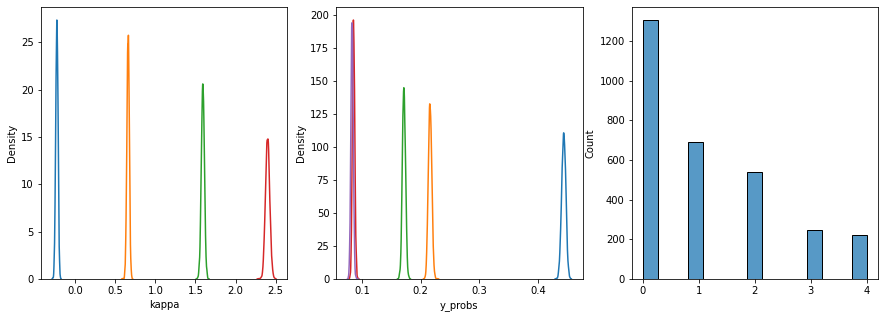

In [ ]:
# Predicciones posteriores
fig, ax = plt.subplots( figsize=(15,5), ncols=3 )
_ = [sns.kdeplot( trace_31.posterior['kappa'][0,:,i], ax=ax[0] ) for i in range(4) ]
_ = [sns.kdeplot( trace_31.posterior['y_probs'][0,:,i], ax=ax[1] ) for i in range(5) ]
_ = sns.histplot( trace_31.posterior_predictive['y'][0,:,50], ax=ax[2] )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


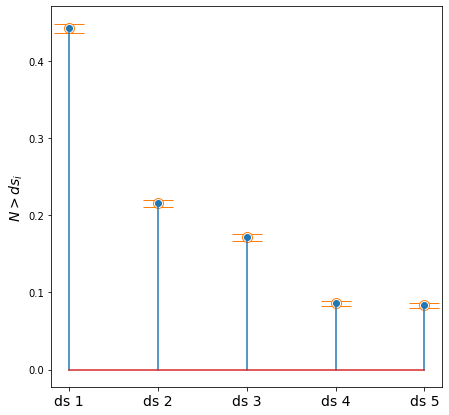

In [ ]:
# Distribución marginal posterior y observaciones
fig, ax = plt.subplots( figsize=(7,7) )

# Posterior
p_mean = trace_31.posterior['y_probs'].mean(['chain','draw'])
p_qi = trace_31.posterior['y_probs'].quantile(q=0.05, dim=['chain','draw'])
p_qf = trace_31.posterior['y_probs'].quantile(q=0.95, dim=['chain','draw'])

ax.errorbar( x=np.arange(1,6), y=p_mean, yerr=np.stack([p_mean-p_qi,p_qf-p_mean]),
             color='C1', capsize=15, linewidth=0, markersize=10, marker='o',
             markerfacecolor='w', zorder=0, elinewidth=1  )

# Proporción de observaciones
ax.stem( np.arange(1,6), np.array([(y==i).sum() for i in range(1,6)])/y.size )

ax.set_xticks( np.arange(1,6) )
ax.set_xticklabels( ['ds '+str(i+1) for i in range(Nk)], fontsize=14 )
ax.set_ylabel(r'$N > ds_i$', fontsize=14);

### Con predictores

In [ ]:
# Observaciones
x = df_nepal_clean['logPGA'].to_numpy()
x = (x-x.mean())/x.std()
y = df_nepal_clean['damage_grade_cat'].to_numpy()

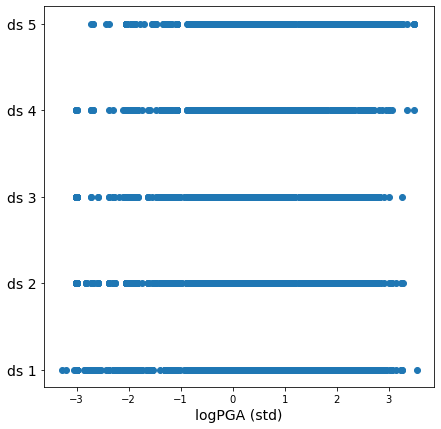

In [ ]:
# Gráfico de observaciones
fig, ax = plt.subplots( figsize=(7,7) )

ax.plot( x, y, 'C0o' )

ax.set_xlabel('logPGA (std)', fontsize=14)
ax.set_yticks( np.arange(1,6) )
ax.set_yticklabels( ['ds '+str(i+1) for i in range(Nk)], fontsize=14 );

In [ ]:
# Regresión con log(PGA) como predictor
with pm.Model() as model_32:
    
    X = pm.MutableData( "x", x )
    
    # Priori
    kappa = pm.Normal( "kappa", 0.0, 1.5, 
                       transform=pm.distributions.transforms.ordered,
                       shape=4, initval=np.arange(4) - 2 )
    beta = pm.Normal("beta", mu=0, sigma=2)

    # Regresión
    phi = pm.Deterministic( "phi", beta * X )
    
    # Verosimilitud
    Y = pm.OrderedLogistic("y", phi, kappa, observed=y-1)

    # Posterior de parámetros
    trace_32 = pm.sample( 1000, tune=2000, cores=2 )

    # Posterior predictiva de y
    pm.sample_posterior_predictive( trace_32, extend_inferencedata=True )

In [ ]:
# Simulaciones posteriores predictivas para xtest (para plotear mejor)
xtest = np.arange( -15, 8, 0.2 )
with model_32:
    pm.set_data({"x":xtest})
    ppc_32 = pm.sample_posterior_predictive( trace_32,
                                             var_names=['y','phi','y_probs'] )

In [ ]:
from matplotlib.ticker import MultipleLocator
# Gráfico de distribuciones posteriores

# Probabilidad de excedencia de cada categoría
p = ppc_32.posterior_predictive['y_probs'] # P[DS=dsi]
F = p.cumsum(dim='y_probs_dim_1') # P[DS<=dsi]
q = 1 - F + p # P[DS>=dsi] = 1 - P[DS<=dsi] + P[DS=dsi]

# Ploteo
fig, ax = plt.subplots( figsize=(6,6) )

# Graficar eje x en escala real (no estandarizada)
xxtest = xtest * df_nepal_clean['logPGA'].std() + df_nepal_clean['logPGA'].mean()
for i in range(5):
    # Predicción posterior media
    ix = np.argsort( x )
    ax.plot( np.exp(xxtest), p.mean(['chain','draw'])[:,i],
             color='C'+str(i), label='grado '+str(i+1) )
    # HDI
    az.plot_hdi( np.exp(xxtest), p[:,:,:,i], hdi_prob=0.9, color='C'+str(i) )

# Formateo de ejes
ax.set_xticks([0,0.5,1,1.5])
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.yaxis.set_minor_locator(MultipleLocator(0.25/2))
ax.set_xlim([-0.05,1.55])
ax.set_ylim([-0.05,1.05])
ax.set_xlabel('PGA (std)')
ax.set_ylabel(r'$P( DS > ds_i )$')
ax.grid( which='both', alpha=.4 )
ax.legend();

### Comparación con modelos logit individuales

In [ ]:
# Inferencia de 5 modelos logit (bernoulli) por separado para cada categoría
with pm.Model() as model_33:
    
    X = pm.MutableData( "x", x )
    
    alpha = pm.Normal("alpha", 0.0, 1.5, shape=5)
    beta = pm.Normal("beta", 0.0, 1.0, shape=5)

    # Probabilidades de cada categoría
    p1 = pm.Deterministic("p1", pm.math.invlogit( alpha[0] + beta[0] * X ) )
    p2 = pm.Deterministic("p2", pm.math.invlogit( alpha[1] + beta[1] * X ) )
    p3 = pm.Deterministic("p3", pm.math.invlogit( alpha[2] + beta[2] * X ) )
    p4 = pm.Deterministic("p4", pm.math.invlogit( alpha[3] + beta[3] * X ) )
    p5 = pm.Deterministic("p5", pm.math.invlogit( alpha[4] + beta[4] * X ) )
    p = pm.Deterministic("p", pm.math.stack([p1,p2,p3,p4,p5]))

    # Cada regresión logística tiene sus propias observaciones                  
    Y1 = pm.Bernoulli("y1", p=p1, observed=1*(y>=1))
    Y2 = pm.Bernoulli("y2", p=p2, observed=1*(y>=2))
    Y3 = pm.Bernoulli("y3", p=p3, observed=1*(y>=3))
    Y4 = pm.Bernoulli("y4", p=p4, observed=1*(y>=4))
    Y5 = pm.Bernoulli("y5", p=p5, observed=1*(y>=5))
    
    # Simulaciones posteriores
    trace_33 = pm.sample( 1000, tune=2000, cores=2 )

In [ ]:
# Simulaciones posteriores predictivas para xtest (para plotear mejor)
xtest = np.arange( -15, 8, 0.2 )
with model_33:
    pm.set_data({"x":xtest})
    ppc_33 = pm.sample_posterior_predictive( trace_33, var_names=['p'] )

In [ ]:
# Probabilidad de excedencia de cada categoría
p = ppc_33.posterior_predictive['p'] # P[DS>=dsi]

# Ploteo
fig, ax = plt.subplots( figsize=(6,6) )

# Graficar eje x en escala real (no estandarizada)
xxtest = xtest * df_nepal_clean['logPGA'].std() + df_nepal_clean['logPGA'].mean()
for i in range(5):
    # Predicción posterior media
    ix = np.argsort( x )
    ax.plot( np.exp(xxtest), p.mean(['chain','draw'])[i,:],
             color='C'+str(i), label='ds '+str(i+1) )
    # HDI
    az.plot_hdi( np.exp(xxtest), p[:,:,i,:], hdi_prob=0.9, color='C'+str(i) )

# Formateo de ejes
ax.set_xticks([0,0.5,1,1.5])
ax.xaxis.set_minor_locator(MultipleLocator(0.25))
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.yaxis.set_minor_locator(MultipleLocator(0.25/2))
ax.set_xlim([-0.05,1.55])
ax.set_ylim([-0.05,1.05])
ax.set_xlabel('PGA (std)')
ax.set_ylabel(r'$P\left[ DS > ds_i \right]$')
ax.grid( which='both', alpha=.4 )
ax.legend();

## Ejemplo 4: Categorías ordenadas como predictores

Regresión del tipo de suelo de fundación (categórica) en función del log(PGA) (continua) y el grado de daño (categórica ordinal)

In [ ]:
df_nepal_clean['land_surface_condition'] = df_nepal_clean['land_surface_condition'].astype('category')
cat_codes = { 'Flat': 0, 'Moderate slope': 1, 'Steep slope': 2 }
df_nepal_clean['land_cat'] = df_nepal_clean['land_surface_condition'].cat.rename_categories( cat_codes )
df_nepal_clean.head()

In [ ]:
df_nepal_clean['land_surface_condition'].value_counts()

Flat              16411
Moderate slope     2863
Steep slope         769
Name: land_surface_condition, dtype: int64

In [ ]:
# Observaciones
x1 = df_nepal_clean['logPGA'].to_numpy()
x2 = df_nepal_clean['damage_grade_cat'].to_numpy()
y = df_nepal_clean['land_surface_condition'].to_numpy()

In [ ]:
# Ploteo del histograma de las observaciones y
sns.histplot( data=df_nepal_clean, x='land_surface_condition' )

# Ploteao de observaciones incluyendo predictores
sns.scatterplot( data=df_nepal_clean, x='logPGA', y='damage_grade_cat',
                 hue='land_surface_condition' )

In [ ]:
# Regresión categórica contra log(PGA) y grado de daño (categórica ordinal)
with pm.Model() as model_41:
    
    # Distribuciones a priori
    alpha = pm.Normal("alpha", 0.0, 1.5, shape=2)  # intercepts
    beta = pm.Normal("beta", 0.0, 1.0, shape=2)  # coefficients on logPGA
    gamma = pm.Normal("gamma", 0.0, 1.0, shape=2)  # coefficients on DS
    delta = pm.Dirichlet("delta", np.repeat(2.0, 5), shape=4) #
    delta_j = at.concatenate([at.zeros(1), delta])
    delta_j_cumulative = at.cumsum( delta_j )

    # Scores
    s0 = pm.math.zeros_like( X1 ) # pivot
    s1 = alpha[0] + beta[0] * X1 + gamma[0] * delta_j_cumulative[x2-1]
    s2 = alpha[1] + beta[1] * X1 + gamma[1] * delta_j_cumulative[x2-1]
    s = pm.math.stack([s0, s1, s2]).T

    # Probabilidades
    p_ = pm.Deterministic( "p_", at.nnet.softmax(s,axis=-1) )

    # Verosimilitud
    Y = pm.Categorical( "y", p=p_, observed=y )
    
    # Simulaciones posteriores
    trace_41 = pm.sample( 3000, tune=2000, cores=2 )

    # Simulaciones predictivas
    pm.sample_posterior_predictive( trace_41, extend_inferencedata=True )

In [ ]:
# Regresión categórica contra log(PGA)
with pm.Model() as model_42:
    
    # Distribuciones a priori
    alpha = pm.Normal("alpha", 0.0, 1.5, shape=2)  # intercepts
    beta = pm.Normal("beta", 0.0, 1.0, shape=2)  # coefficients on logPGA

    # Scores
    s0 = pm.math.zeros_like( x1 ) # pivot
    s1 = alpha[0] + beta[0] * x1
    s2 = alpha[1] + beta[1] * x1
    s = pm.math.stack([s0, s1, s2]).T

    # Probabilidades
    p_ = pm.Deterministic( "p_", at.nnet.softmax(s,axis=-1) )

    # Verosimilitud
    Y = pm.Categorical( "y", p=p_, observed=y )
    
    # Simulaciones posteriores
    trace_42 = pm.sample( 3000, tune=2000, cores=2 )

    # Simulaciones predictivas
    pm.sample_posterior_predictive( trace_42, extend_inferencedata=True )

In [ ]:
models_list = {'y ~ log(PGA)': trace_42, 'Y ~ log(PGA) + suelo': trace_41}
models_comp = ax.compare( models_list )

In [ ]:
az.plot_compare( models_comp )

## OFF-ROAD 1: Mixturas y modelos sobre-dispersos

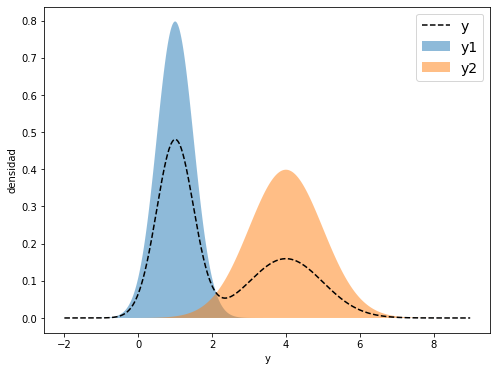

In [ ]:
# Mixtura de 2 normales
xplot = np.arange(-2,9,0.01)
y1 = st.norm.pdf( xplot, loc=1, scale=0.5)
y2 = st.norm.pdf( xplot, loc=4, scale=1)
p=0.6
y = p*y1 + (1-p)*y2

fig, ax = plt.subplots( figsize=(8,6) )

ax.fill_between( xplot, y1=0*xplot, y2=y1, alpha=.5, label='y1')
ax.fill_between( xplot, y1=0*xplot, y2=y2, alpha=.5, label='y2')
ax.plot( xplot, y, 'k--', label='y')

ax.set_xlabel('y')
ax.set_ylabel('densidad')
ax.legend( fontsize=14 );


### Modelo de datos cruzados

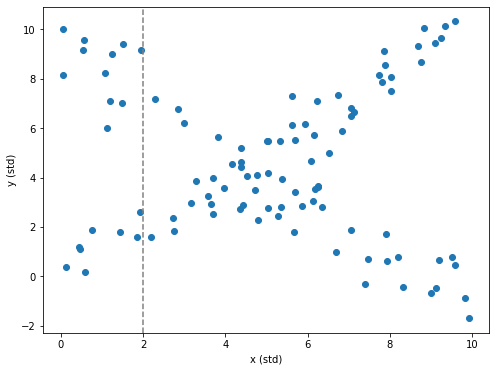

In [ ]:
np.random.seed(1234)
N = 50
x1 = st.uniform.rvs( size=N, loc=0, scale=10 )
x2 = st.uniform.rvs( size=N, loc=0, scale=10 )
y1 = 1*x1 + st.norm.rvs( size=N, scale=0.9 )
y2 = -1.*x2 + 9 + st.norm.rvs( size=N, scale=0.9 )

x = np.hstack([x1,x2])
y = np.hstack([y1,y2])

fig, ax = plt.subplots( figsize=(8,6) )
ax.plot( x, y, 'C0o' )
ax.set_xlabel('x (std)')
ax.set_ylabel('y (std)')
ax.axvline(x=2, color='gray', linestyle='--')

In [ ]:
# Modelo de regresión Normal simple
with pm.Model() as model_51:

    # Priors
    alpha = pm.Normal( "alpha", mu=0, sigma=2 )
    beta = pm.Normal( "beta", mu=0, sigma=2 )
    log_sigma = pm.Normal( "log_sigma", mu=0, sigma=1 )
    
    # Mean
    mu = pm.Deterministic( 'mu', alpha + beta * x )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=np.exp(log_sigma), observed=y )
    
    # Posterior de los parámetros
    trace_51 = pm.sample( 3000, tune=2000, cores=2 )

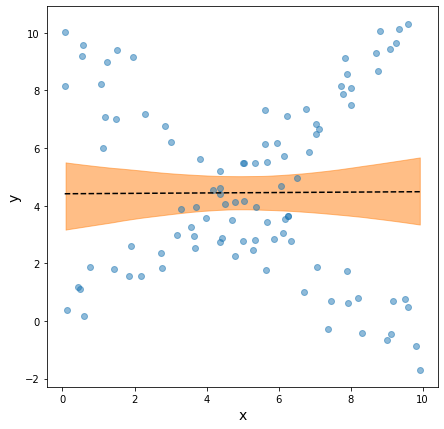

In [ ]:
fig, ax = plt.subplots( figsize=(7,7) )

# Línea media
ix = np.argsort(x)
ax.plot( x[ix], trace_51.posterior['mu'].mean(['chain','draw'])[ix],'k--')

# HDI de mu
az.plot_hdi( x, trace_51.posterior['mu'], color='C1', ax=ax )

# Observaciones
ax.scatter( x, y, alpha=.5 )

# Formateo
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);

In [ ]:
# Modelo de rergesión mixta de dos normales
with pm.Model() as model_52:

    # Priors for weight parameter
    π1 = pm.Uniform('π1', 0, 1)
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sigma=2, shape=2)
    β = pm.Normal('β', mu=0, sigma=2, shape=2,
                   transform=pm.distributions.transforms.ordered,
                   initval=np.arange(2) - 1) 
    σ  = pm.HalfCauchy('σ', 5, shape=2)
     
    μ1 = pm.Deterministic( "mu1", α[0] + β[0]*x )
    μ2 = pm.Deterministic( "mu2", α[1] + β[1]*x )

    mu = pm.math.stack([μ1, μ2]).T
    π = pm.math.stack([π1, 1-π1])
        
    Y = pm.NormalMixture('y', π, mu, sigma=σ, observed=y)

    trace_52 = pm.sample( 3000, tune=2000, cores=2 )

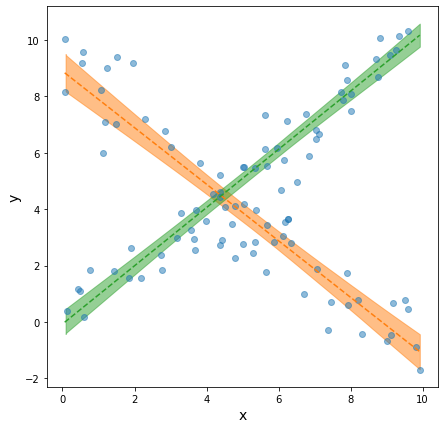

In [ ]:
fig, ax = plt.subplots( figsize=(7,7) )

# Línea media
ix = np.argsort(x)
ax.plot( x[ix], trace_52.posterior['mu1'].mean(['chain','draw'])[ix],'C1--')
az.plot_hdi( x, trace_52.posterior['mu1'], color='C1', ax=ax )

ax.plot( x[ix], trace_52.posterior['mu2'].mean(['chain','draw'])[ix],'C2--')
az.plot_hdi( x, trace_52.posterior['mu2'], color='C2', ax=ax )

# Observaciones
ax.scatter( x, y, alpha=.5 )

# Formateo
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);

### Modelos con outliers

In [ ]:
# Dataset sintético con outliers
np.random.seed(1234)
N = 50
x = st.uniform.rvs( size=N, loc=0, scale=10 )
y = 0.5*x + 2 + st.norm.rvs( size=N, scale=0.1 )

# outliers
N_out = 4
np.random.seed(5234)
ix_out = np.random.choice( x.size, size=N_out, replace=False )
y[ix_out] =  0.5*x[ix_out] + 2 + 4*st.norm.rvs( size=N_out, loc=1, scale=0.1 )

# standardize
x = (x-x.mean())/x.std()
y = (y-y.mean())/y.std()

Text(0, 0.5, 'y (std)')

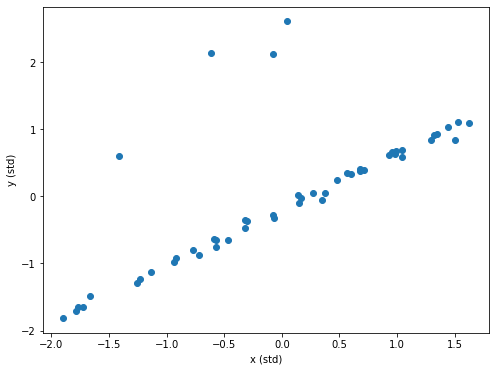

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )
ax.plot( x, y, 'C0o' )
ax.set_xlabel('x (std)')
ax.set_ylabel('y (std)')

In [ ]:
# Modelo de regresión Normal simple
with pm.Model() as model_53:
    
    # Data modificable
    X = pm.MutableData( 'X', x )

    # Priors
    alpha = pm.Normal( "alpha", mu=0, sigma=2 )
    beta = pm.Normal( "beta", mu=0, sigma=2 )
    log_sigma = pm.Normal( "log_sigma", mu=0, sigma=1 )
    
    # Mean
    mu = pm.Deterministic( 'mu', alpha + beta * x )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=np.exp(log_sigma), observed=y )
    
    # Posterior de los parámetros
    trace_53 = pm.sample( 3000, tune=2000, cores=2 )

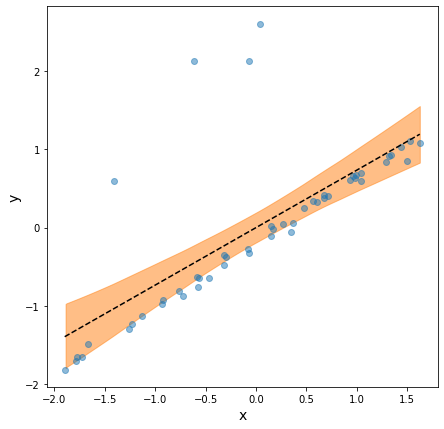

In [ ]:
fig, ax = plt.subplots( figsize=(7,7) )

# Línea media
ix = np.argsort(x)
ax.plot( x[ix], trace_53.posterior['mu'].mean(['chain','draw'])[ix],'k--')
az.plot_hdi( x, trace_53.posterior['mu'], color='C1', ax=ax )

# Observaciones
ax.scatter( x, y, alpha=.5 )

# Formateo
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);

In [ ]:
# Modelo de rergesión mixta de dos normales
with pm.Model() as model_54:

    # Priors for weight parameter
    π1 = pm.Uniform('π1', 0, 1)
    
    # Priors for unknown model parameters
    α = pm.Normal('α', mu=0, sigma=2, shape=2)
    β = pm.Normal('β', mu=0, sigma=2, shape=2) 
    σ  = pm.HalfCauchy('σ', 5, shape=2)
     
    μ1 = pm.Deterministic( "mu1", α[0] + β[0]*x )
    μ2 = pm.Deterministic( "mu2", α[1] + β[1]*x )

    mu = pm.math.stack([μ1, μ2]).T
    π = pm.math.stack([π1, 1-π1])
        
    Y = pm.NormalMixture('y', π, mu, sigma=σ, observed=y)

    trace_54 = pm.sample( 3000, tune=2000, cores=2 )

ERROR:pymc:There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc:There were 81 divergences after tuning. Increase `target_accept` or reparameterize.


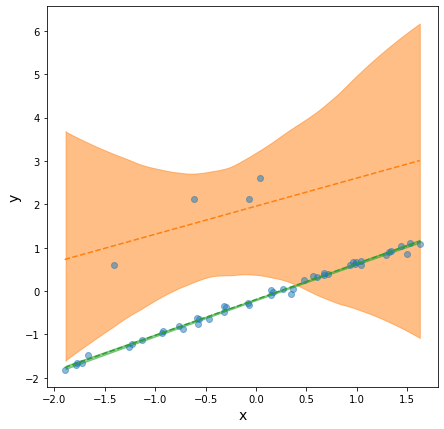

In [ ]:
fig, ax = plt.subplots( figsize=(7,7) )

# Línea media
ix = np.argsort(x)
ax.plot( x[ix], trace_54.posterior['mu1'].mean(['chain','draw'])[ix],'C1--')
az.plot_hdi( x, trace_54.posterior['mu1'], color='C1', ax=ax )

ax.plot( x[ix], trace_54.posterior['mu2'].mean(['chain','draw'])[ix],'C2--')
az.plot_hdi( x, trace_54.posterior['mu2'], color='C2', ax=ax )

# Observaciones
ax.scatter( x, y, alpha=.5 )

# Formateo
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);

In [ ]:
with pm.Model() as model_55:

    # Priors
    alpha = pm.Normal( "alpha", mu=0, sigma=2 )
    beta = pm.Normal( "beta", mu=0, sigma=2 )
    log_sigma = pm.Normal( "log_sigma", mu=0, sigma=1 )
    nu = pm.Exponential("nu", lam=1)
    
    # Mean
    mu = pm.Deterministic( 'mu', alpha + beta * x )
    
    # Modelo
    Y = pm.StudentT( "y", mu=mu, sigma=np.exp(log_sigma), nu=nu, observed=y )
    
    # Posterior de los parámetros
    trace_55 = pm.sample( 3000, tune=2000, cores=2 )

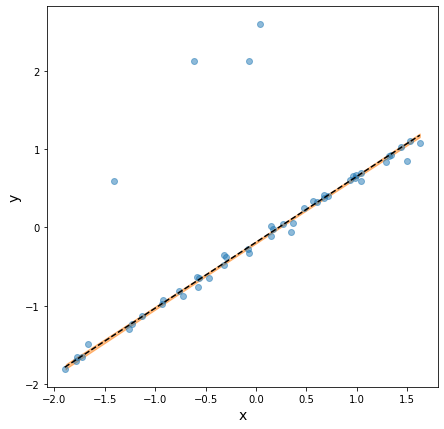

In [ ]:
fig, ax = plt.subplots( figsize=(7,7) )

# Línea media
ix = np.argsort(x)
ax.plot( x[ix], trace_55.posterior['mu'].mean(['chain','draw'])[ix],'k--')
az.plot_hdi( x, trace_55.posterior['mu'], color='C1', ax=ax )

# Observaciones
ax.scatter( x, y, alpha=.5 )

# Formateo
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);

## OFF-ROAD 2: Modelos inflados

### Inflados en 0: cantidad de lluvia diaria

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving daily_climate_data_us_city.csv to daily_climate_data_us_city.csv


In [ ]:
#Se crea un DataFrame
df_lluvias = pd.read_csv(io.BytesIO(uploaded['daily_climate_data_us_city.csv']))
df_lluvias.head()

,Unnamed: 0,Date,tmax,tmin,prcp
0,1,1893-01-01,50.0,42.0,0.52
1,2,1893-01-02,48.0,38.0,0.03
2,3,1893-01-03,43.0,38.0,0.00
3,4,1893-01-04,44.0,37.0,0.00
4,5,1893-01-05,44.0,35.0,0.00


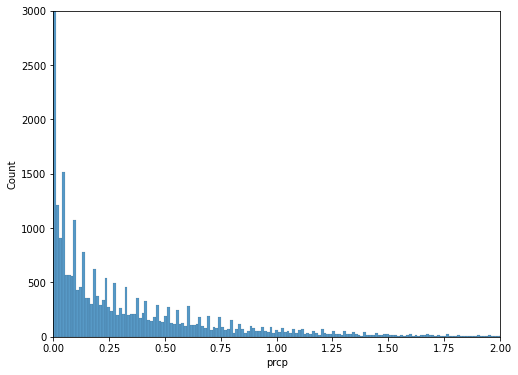

In [ ]:
fig, ax = plt.subplots( figsize=(8,6) )
sns.histplot( df_lluvias['prcp'] )
ax.set_ylim([0,3000])
ax.set_xlim([0,2]);

### Observaciones censuradas

Ejemplo obtenido de: https://github.com/pymc-devs/pymc-examples/blob/main/examples/generalized_linear_models/GLM-truncated-censored-regression.ipynb

In [ ]:
np.random.seed(1234)
slope, intercept, σ, N = 1, 0, 2, 200
x = st.uniform.rvs(loc=-10, scale=20, size=N)
y = st.norm.rvs(loc=slope * x + intercept, scale=σ)

# Censoring
bounds = [-5,5]
cy = 1*y
cy[y <= bounds[0]] = bounds[0]
cy[y >= bounds[1]] = bounds[1]

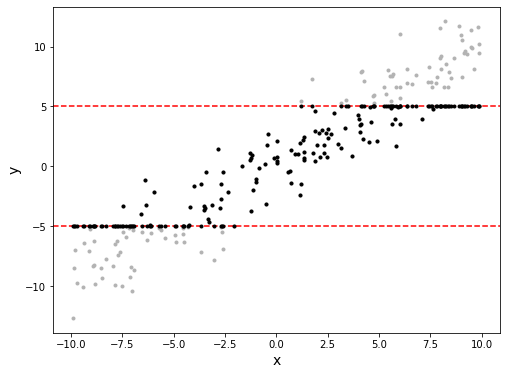

In [ ]:
fig, ax = plt.subplots( figsize=(8, 6) )

ax.plot(x, y, ".", c=[0.7, 0.7, 0.7])
ax.axhline(bounds[0], c="r", ls="--")
ax.axhline(bounds[1], c="r", ls="--")

ax.plot(x, cy, ".", c=[0, 0, 0])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);

In [ ]:
# Modelo de regresión Normal simple
with pm.Model() as model_61:
    
    # Data modificable
    X = pm.MutableData( 'X', x )

    # Priors
    alpha = pm.Normal( "alpha", mu=0, sigma=2 )
    beta = pm.Normal( "beta", mu=0, sigma=2 )
    log_sigma = pm.Normal( "log_sigma", mu=0, sigma=1 )
    
    # Mean
    mu = pm.Deterministic( 'mu', alpha + beta * x )
    
    # Modelo
    Y = pm.Normal( "y", mu=mu, sigma=np.exp(log_sigma), observed=cy )
    
    # Posterior de los parámetros
    trace_61 = pm.sample( 3000, tune=2000, cores=2 )

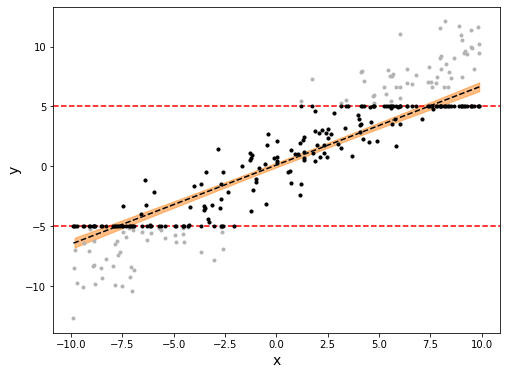

In [ ]:
fig, ax = plt.subplots( figsize=(8, 6) )

# Línea media
ix = np.argsort(x)
ax.plot( x[ix], trace_61.posterior['mu'].mean(['chain','draw'])[ix],'k--')
az.plot_hdi( x, trace_61.posterior['mu'], color='C1', ax=ax )

ax.plot(x, y, ".", c=[0.7, 0.7, 0.7])
ax.axhline(bounds[0], c="r", ls="--")
ax.axhline(bounds[1], c="r", ls="--")

ax.plot(x, cy, ".", c=[0, 0, 0])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);

In [ ]:
with pm.Model() as model_62:

    # Prioris
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Mean
    mu = pm.Deterministic( 'mu', alpha + beta * x )

    # Distribución original
    y_latente = pm.Normal.dist(mu=mu, sigma=sigma)

    # Verosimilitud
    obs = pm.Censored("obs", y_latente, lower=bounds[0], upper=bounds[1], observed=cy)
    
    # Posterior de los parámetros
    trace_62 = pm.sample( 3000, tune=2000, cores=2, init='adapt_diag' )

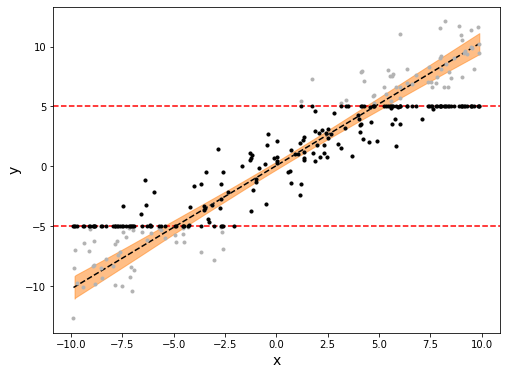

In [ ]:
fig, ax = plt.subplots( figsize=(8, 6) )

# Línea media
ix = np.argsort(x)
ax.plot( x[ix], trace_62.posterior['mu'].mean(['chain','draw'])[ix],'k--')
az.plot_hdi( x, trace_62.posterior['mu'], color='C1', ax=ax )

ax.plot(x, y, ".", c=[0.7, 0.7, 0.7])
ax.axhline(bounds[0], c="r", ls="--")
ax.axhline(bounds[1], c="r", ls="--")

ax.plot(x, cy, ".", c=[0, 0, 0])
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('y', fontsize=14);